In [ ]:
%pip install --quiet --upgrade langchain langchain-text-splitters langchain-community langgraph
%pip install -qU langsmith
%pip install -qU langchain-ollama
%pip install -U ollama
%pip install -qU langchain-chroma
%pip install -qU pypdf

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [14]:
from dotenv import load_dotenv
import os

# Загружаем переменные из .env
load_dotenv()

# Получаем переменные окружения
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")

In [15]:
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY

In [16]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.1",
    temperature=1
)

In [17]:
from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(model="llama3.1")

In [18]:
from langchain_chroma import Chroma

vector_store = Chroma(embedding_function=embeddings)

In [19]:
# from langchain_core.messages import AIMessage

# messages = [
#     (
#         "system",
#         "You are a helpful assistant who gives clear, useful and formal answers, no fantasizing, no cheating. Gives answers in RUSSIAN LANGUAGE!",
#     ),
#     ("human", "I love programming."),
# ]
# ai_msg = llm.invoke(messages)
# ai_msg

In [20]:
import bs4
from langchain import hub
from langchain.prompts import PromptTemplate
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_community.document_loaders import PyPDFLoader

file_path = ("docs/Хакатон 2_описание задания.pdf")
loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)
# print(f"{pages[0].metadata}\n")
# print(pages[0].page_content)

In [21]:

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(pages)
# print(f"Split blog post into {len(all_splits)} sub-documents.")
# print(all_splits[0])

In [22]:

# Index chunks
document_ids = vector_store.add_documents(documents=all_splits)
# print(f"Indexed {len(document_ids)} documents.")


In [23]:
query = "Какое задание на хакатоне?"
docs = vector_store.similarity_search(query)
print(docs[0].page_content)

 Решение не должно требовать существенного увеличения программно-
технических ресурсов.
 При создании решения должны быть минимизированы трудозатраты, 
особенно программистов.
 Если будут использоваться сторонние решения, то продукт должен 
быть open-source, лицензионное соглашение должно позволять 
использовать его в коммерческих целях.


In [24]:
# Получаем текущий промпт
prompt = hub.pull("rlm/rag-prompt")

# Создаём новый промпт с изменённым текстом
new_prompt = PromptTemplate(
    input_variables=prompt.input_variables,
    template=(
        "You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. "
        "If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise. "
        "Gives answers in RUSSIAN LANGUAGE!\n"
        "Question: {question}\n"
        "Context: {context}\n"
        "Answer:"
    )
)

# example_messages = new_prompt.invoke(
#     {
#         "context": "На хакатоне вам предстоит выполнить задание, которое будет оцениваться по следующим критериям: 1. Сложность задачи. 2. Оригинальность решения. 3. Качество кода. 4. Презентация проекта. 5. Время выполнения задания. 6. Команда. 7. Способность к коммуникации. 8. Способность к самостоятельному решению задач. 9. Способность к работе в команде. 10. Способность к анализу и обобщению информации. 11. Способность к самостоятельному поиску информации. 12. Способность к самостоятельному обучению. 13. Способность к самостоятельному решению проблем. 14. Способность к самостоятельному принятию решений. 15. Способность к самостоятельному принятию ответственности. 16. Способность к самостоятельному принятию решений в сложных ситуациях. 17. Способность к самостоятельному принятию решений в экстремальных ситуациях. 18. Способность к самостоятельному принятию решений в критических ситуациях. 19. Способность к самостоятельному принятию решений в экстренных ситуациях. 20. Способность к самостоятельному принятию решений в нестандартных ситуациях. 21. Способность к самостоятельному принятию решений в нестандартных ситуациях. 22. Способность к самостоятельному принятию решений в нестандартных ситу", 
#         "question": "Какое задание на хакатоне?"
#     }
# ).to_messages()

# assert len(example_messages) == 1
# print(example_messages[0].content)

In [25]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [26]:
# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

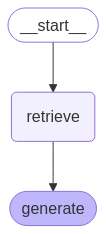

In [29]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
result = graph.invoke({"question": "ПЕречисли требования к заданию хакатона?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='a0e1f505-dedd-4a8a-8b17-46a404025c1a', metadata={'author': 'Зубкова Елена Александровна', 'creationdate': '2025-03-15T09:07:12+03:00', 'creator': 'Writer', 'page': 1, 'page_label': '2', 'producer': 'LibreOffice 24.2', 'source': 'docs/Хакатон 2_описание задания.pdf', 'total_pages': 2}, page_content='\uf0b7 Решение не должно требовать существенного увеличения программно-\nтехнических ресурсов.\n\uf0b7 При создании решения должны быть минимизированы трудозатраты, \nособенно программистов.\n\uf0b7 Если будут использоваться сторонние решения, то продукт должен \nбыть open-source, лицензионное соглашение должно позволять \nиспользовать его в коммерческих целях.'), Document(id='7ef8b787-7900-4df5-b65b-a32cc7a71de0', metadata={'author': 'Зубкова Елена Александровна', 'creationdate': '2025-03-15T09:07:12+03:00', 'creator': 'Writer', 'page': 1, 'page_label': '2', 'producer': 'LibreOffice 24.2', 'source': 'docs/Хакатон 2_описание задания.pdf', 'total_pages': 2}, page_conten